In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
#infile="data/data/F61C1E0B-F61C-B044-9B45-A711DABCFB75_skim_2ElIdPt20.root"
infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root"

In [4]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [5]:
Electron = events.Electron
Photon   = events.Photon

### Particle Selection

In [6]:
def Particle_selection(ele,pho):
    # Electron selection
    EleSelmask = (ele.pt > 25) & (np.abs(ele.eta) < 2.5) & (ele.cutBased > 2)

    # Photon selection
    # 0 Fail 1 Loose 2 Medium 3 Tight
    # -- HoE cut is added manually
    #PhoSelmaskEE = (pho.pt > 25) & (pho.cutBased > 1) &  pho.isScEtaEE & (pho.hoe < 0.0326)
    #PhoSelmaskEB = (pho.pt > 25) & (pho.cutBased > 1) &  pho.isScEtaEB & (pho.hoe < 0.02197)
    #PhoSelmask = PhoSelmaskEE | PhoSelmaskEB
    
    # -- Original Photon selection
    PhoSelmask = (pho.pt > 25) & (pho.cutBased > 1)
    return EleSelmask,PhoSelmask

In [7]:
# Event Selection
Electron_mask, Photon_mask  = Particle_selection(Electron,Photon)
Ele_channel_mask = ak.num(Electron[Electron_mask]) > 1
Pho_channel_mask = ak.num(Photon[Photon_mask]) > 0
Ele_channel_events = events[Ele_channel_mask & Pho_channel_mask]

### Make Paricle array from selected events

In [8]:
Ele = Ele_channel_events.Electron
Pho = Ele_channel_events.Photon

In [9]:
Electron_mask,Photon_mask = Particle_selection(Ele,Pho)
Ele_sel = Ele[Electron_mask]
Pho_sel = Pho[Photon_mask]

# Helper function: High PT argmax
def make_leading_pair(target,base):

    return target[ak.argmax(base.pt,axis=1,keepdims=True)]

leading_pho = make_leading_pair(Pho_sel,Pho_sel)

### Select Electron pair

In [10]:
# Electron pair
ele_pairs = ak.combinations(Ele_sel,2,axis=1)
ele_left, ele_right = ak.unzip(ele_pairs)
diele = ele_left + ele_right


# -- Only Leading pair --
leading_diele = make_leading_pair(diele,diele)
leading_ele   = make_leading_pair(ele_left,diele)
subleading_ele= make_leading_pair(ele_right,diele)

### Calculate Delta R

In [11]:
## -- Helper function for making delta_R
import math
def dR(ele,pho):
    # -- delta eta -- #
    deta = abs(ele.eta - pho.eta)
    
    # -- delta phi == # 
    if abs(ele.phi - pho.phi) > math.pi: 
        dphi = 2*math.pi - abs(ele.phi - pho.phi)
    else:
        dphi = abs(ele.phi - pho.phi)
        
    # -- delta R -- #
    return np.sqrt(deta*deta + dphi*dphi)

In [12]:
%%time
dR_leading_ele=[]
dR_subleading_ele=[]

Low_dR_ele1_pt=[]
Low_dR_ele2_pt=[]
Low_dR_pho_e1_pt=[]
Low_dR_pho_e2_pt=[]

for evt,photon in enumerate(Pho_sel):
    for pho_idx,_ in enumerate(photon):
               
        dR_e1= dR(leading_ele[evt][0],Pho_sel[evt][pho_idx])
        dR_e2= dR(subleading_ele[evt][0],Pho_sel[evt][pho_idx])        
        dR_leading_ele.append(dR_e1)
        dR_subleading_ele.append(dR_e2)
        
        
        if dR_e1 <= 0.4:
            Low_dR_ele1_pt.append(leading_ele[evt][0].pt)
            Low_dR_pho_e1_pt.append(Pho_sel[evt][pho_idx].pt)
        if dR_e2 <= 0.4:
            Low_dR_ele2_pt.append(subleading_ele[evt][0].pt)
            Low_dR_pho_e2_pt.append(Pho_sel[evt][pho_idx].pt)

Wall time: 10.3 s


### dR histogram and plot(elept vs phopt) in low dR region

Text(0.5, 1.0, 'dR(ele1,pho)')

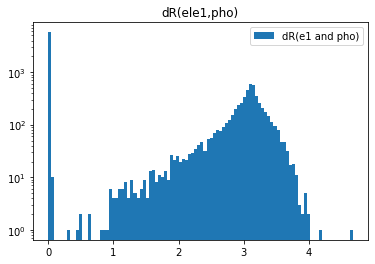

In [13]:
plt.hist(dR_leading_ele,bins=100,label='dR(e1 and pho)')
plt.yscale('log')
#plt.xlim(0,)
plt.legend()
plt.title('dR(ele1,pho)')

Text(0.5, 1.0, 'dR(ele1,pho) zoom')

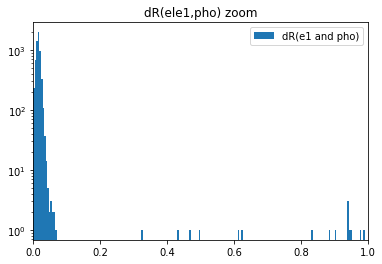

In [14]:
plt.hist(dR_leading_ele,bins=1000,label='dR(e1 and pho)')
plt.yscale('log')
plt.xlim(0,1)
plt.legend()
plt.title('dR(ele1,pho) zoom')

Text(0.5, 1.0, 'dR(ele2,pho)')

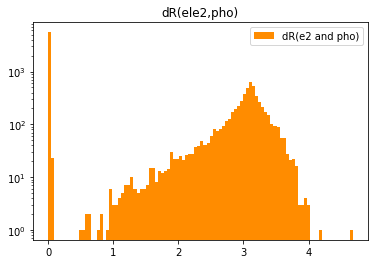

In [15]:
plt.close()
plt.hist(dR_subleading_ele,bins=100,color='darkorange',label='dR(e2 and pho)',)
plt.yscale('log')
plt.legend()
plt.title('dR(ele2,pho)')

Text(0.5, 1.0, 'dR(ele2,pho) zoom')

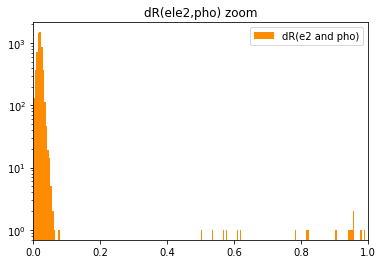

In [16]:
plt.close()
plt.hist(dR_subleading_ele,bins=1000,color='darkorange',label='dR(e2 and pho)',)
plt.yscale('log')
plt.legend()
plt.xlim(0,1)
plt.title('dR(ele2,pho) zoom')

Text(0.5, 1.0, 'ele1pt vs phopt in dR<0.4')

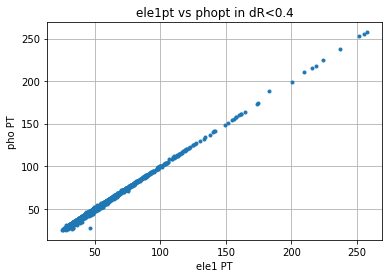

In [17]:
plt.plot(Low_dR_ele1_pt,Low_dR_pho_e1_pt,'.')
plt.grid()
plt.xlabel('ele1 PT')
plt.ylabel('pho PT')
plt.title('ele1pt vs phopt in dR<0.4')

Text(0.5, 1.0, 'ele2pt vs phopt in dR<0.4')

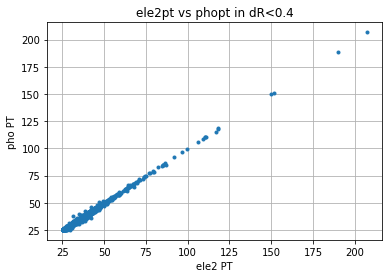

In [18]:
plt.plot(Low_dR_ele2_pt,Low_dR_pho_e2_pt,'.')
plt.grid()
plt.xlabel('ele2 PT')
plt.ylabel('pho PT')
plt.title('ele2pt vs phopt in dR<0.4')